    # Face Validity

## 1. Noisy Hopfiled  Networks reproduce dynamics of th resting state

## 2. Task-activity maps differently to the Hopfield embeddings than rest
    - energy
    - attractor
    - location/trajectory

## 3. Hopfield-embeddings explain taks-activations better than resting state by itself


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from nilearn import plotting
from sklearn.preprocessing import StandardScaler
from connattractor import network, analysis
from scipy import interpolate
%load_ext autoreload
%autoreload 1
%aimport connattractor.network
%aimport connattractor.analysis

In [2]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx.shape

(122, 122)

## Hopfield embeddings and resting state data
First look at the speed of state transitions, it's adjustable with the noise_coef in the simulations

## let's look at the ditribution of the data on the 2D Hopfiled-projection

In [4]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


In [8]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=42)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=1000,random_state=42)

100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


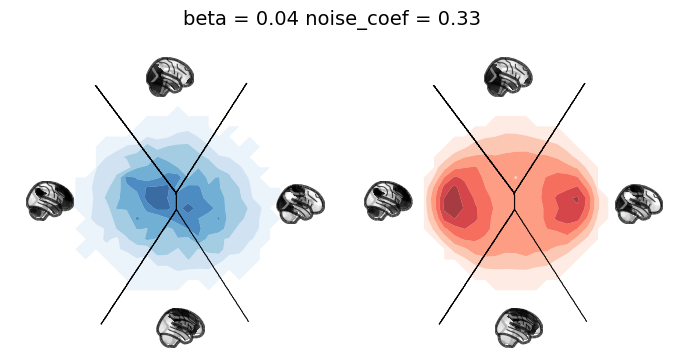

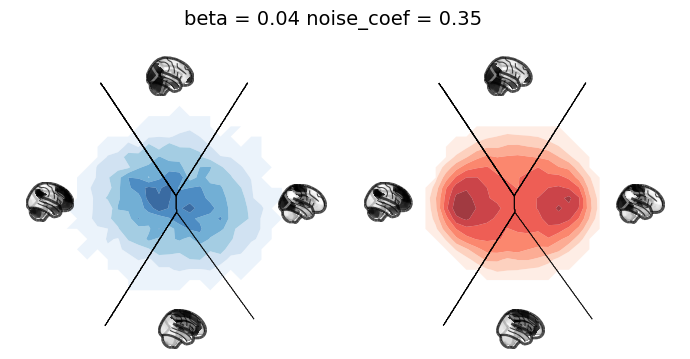

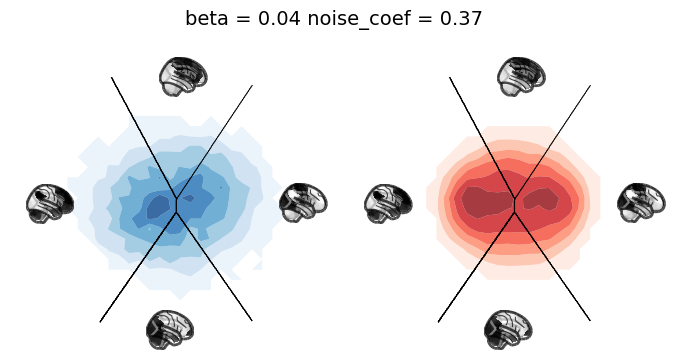

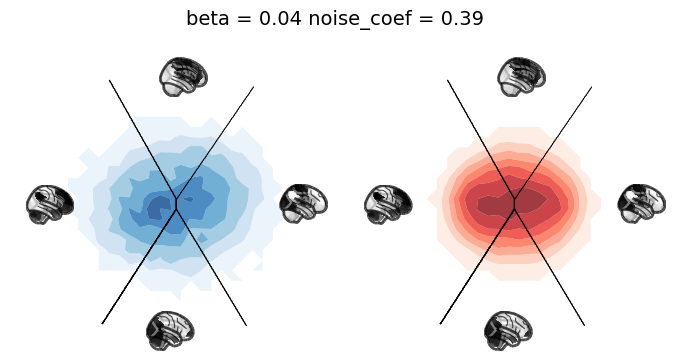

In [10]:
for i in simresults_all.keys():

    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
    fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
    hopfield_embeddings_all[i].plot(all_ts, plot_type='contourf', ax=ax[0],
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[0].set_yticks([])
    ax[0].grid(False)

    hopfield_embeddings_all[i].plot(simresults_all[i].states, plot_type='contourf', ax=ax[1],
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Reds',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[1].set_yticks([])
    ax[1].grid(False)
    plt.savefig('../data_out/fig/emp_vs_generated_beta_' + str(i) + '.pdf')
    plt.show()


In [201]:
noise = 0.37
embeddings = hopfield_embeddings_all[noise].embedding_model.transform(all_ts)
 from sklearn.mixture import BayesianGaussianMixture

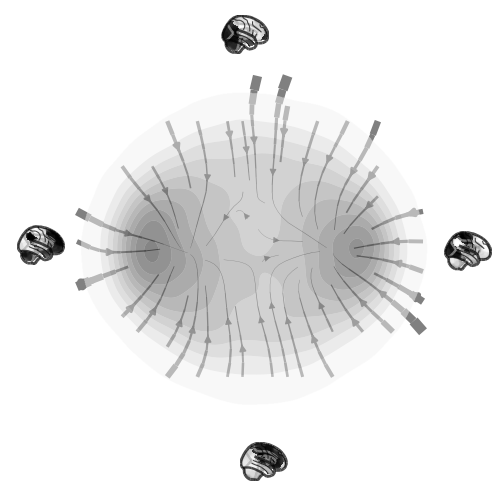

In [11]:

noise = 0.33
ax = hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='contourf',
                             density_bins=1000, density_sigma=20, levels=12, alpha=0.5, cmap='gray_r',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

ax = hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='stream', density=1, bins=12, linewidth=8,
                             ax=ax,
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

## Reconstructing step size

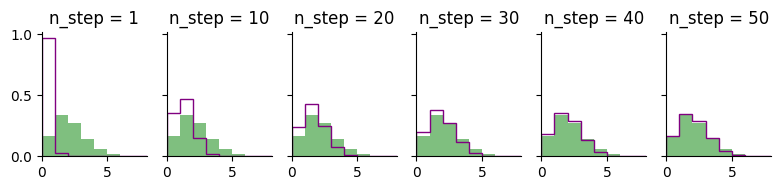

In [27]:
noise = 0.37

# load data
from glob import glob
import os

fig, ax = plt.subplots(ncols=6, figsize=(8, 2), sharey=True, sharex=True)


all_ts = []
root_dir = '../data_in/ex_timeseries/'

norms_emp = []
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    
    activations = StandardScaler().fit_transform(ts.reshape(1,-1).T).T
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(ts)
    # no scrubbing to preserve continuity
    deltas = embedded[1:, :] - embedded[:-1, :]
    norms_emp.append(np.sqrt(deltas[:,0]**2 + deltas[:,1]**2))

from matplotlib import cm
maxstep=20
for i, step in enumerate([1, 10, 20, 30, 40, 50]):
    # calculate norms
    activations = StandardScaler().fit_transform(simresults_all[noise].states.T).T
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states)
    deltas = embedded[step:, :] - embedded[:-step, :]
    norms_sim = np.sqrt(deltas[:,0]**2 + deltas[:,1]**2)
    
    ax[i].hist(np.array(norms_emp).flatten(), bins=12, histtype='bar', range=(0,12),
         alpha=0.5, density=True, color='green')
    ax[i].set(title='n_step = ' + str(step))
    
    ax[i].hist(norms_sim, bins=12, histtype='step', range=(0,12),
             density=True, color="purple")
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
plt.gca().set_xlim((0, 8))
plt.tight_layout()
plt.savefig('../data_out/fig/step_convergence.pdf')


## Reconstruction of the connectome

In [28]:
from nilearn import plotting

def plot_matrix(mat, **kwargs):
    
    mat[range(mat.shape[0]), range(mat.shape[0])] = 0
    
    atlas_labels = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t')
    
    labels = atlas_labels.labels.values
    modules = atlas_labels.modules.values
    
    fig = plt.gcf()
    fig.set_size_inches(3, 3)
    ax = fig.add_axes([0,0,1,1], frameon=False)
    
    plotting.plot_matrix(mat, **kwargs, zorder=0, axes=ax)
    
    prev=""
    idx=0
    
    
    for i in range(len(labels)):
        if modules[i]!=prev:
            print(modules[i])
            ax.plot([-5, len(labels) + 0.5], [i-0.5, i-0.5], linewidth=1, color='gray', zorder=100)
            ax.plot([i - 0.5, i - 0.5], [-5, len(labels) + 0.5], linewidth=1, color='gray', zorder=100)

            idx=idx+1
            prev=modules[i]

/home/tspisak/src/connattractor/venv/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


CER
DMnet
FPnet_VISDN
LIMnet
MOTnet
VATTnet_SALnet_BG_THAL
VISnet


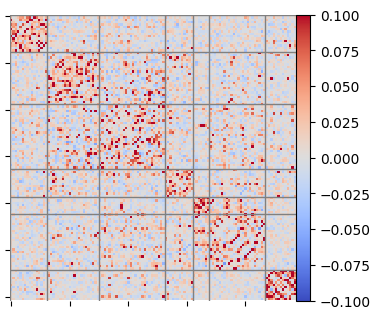

In [29]:
from nilearn.connectome import ConnectivityMeasure

plot_matrix(mtx.values, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_empirical.pdf')

100%|██████████| 7200/7200 [00:02<00:00, 2635.02it/s]
/home/tspisak/src/connattractor/venv/lib/python3.10/site-packages/nilearn/plotting/matrix_plotting.py:293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


CER
DMnet
FPnet_VISDN
LIMnet
MOTnet
VATTnet_SALnet_BG_THAL
VISnet


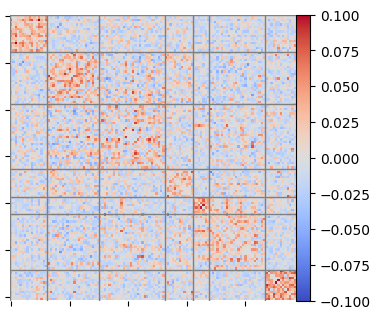

In [30]:
sim = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=7200, beta=0.04)
correlation_measure = ConnectivityMeasure(kind="partial correlation")
reconstructed_matrix = correlation_measure.fit_transform([sim.states])[0]
plot_matrix(reconstructed_matrix, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_reconstructed.pdf')

# Hopfiled embedding of task-based timeseries
- energy
- attractor
- embedding of task vs. rest

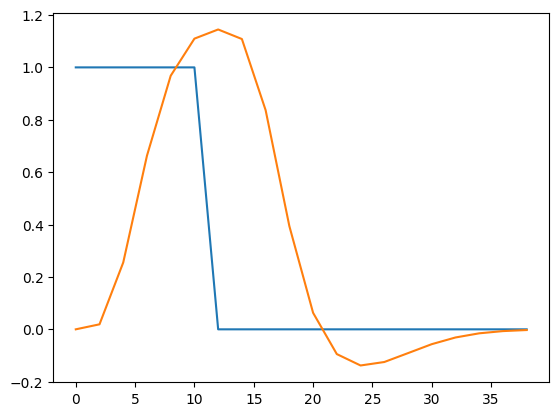

In [31]:
from nilearn.glm.first_level import compute_regressor
signal, _labels = compute_regressor(
    exp_condition = np.array((0, 12, 1)).reshape(3, 1),
    hrf_model = 'spm',
    frame_times = np.arange(0,40, step=2))

plt.plot(np.arange(0,40, step=2), [1]*6 + [0]*14)
plt.plot(np.arange(0,40, step=2), signal)

In [62]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts.txt', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_start = 0

    for i in events.index:    
        onset = int(np.round(events.loc[i, "onset"]/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        rest = np.vstack((rest, ts[rest_start:(onset + int(np.round(0/_TR_))), :]))
        task = np.vstack((task, ts[(onset + int(np.round(6/_TR_))):end, :]))
        
        rest_start = end + int(np.round(6/_TR_))
    
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape

perc. scrubbed: 0.8133971291866029
perc. scrubbed: 0.5741626794258373
perc. scrubbed: 0.6267942583732058
perc. scrubbed: 0.7081339712918661


(286, 122)

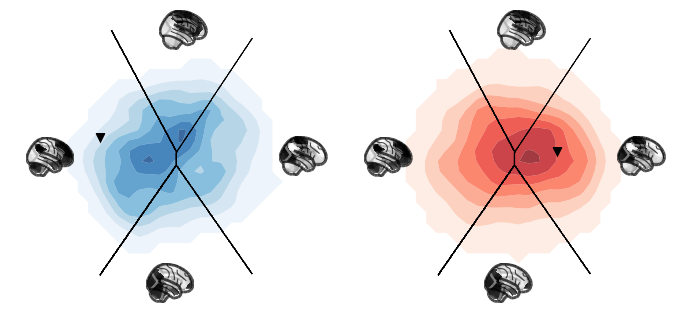

In [185]:
noise = 0.37

fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax[0],
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='scatter',#'glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[0].set_yticks([])
ax[0].grid(False)

hopfield_embeddings_all[noise].plot(np.mean(rest, axis=0).reshape(1,-1), plot_type='scatter', ax=ax[0],
                    marker='v', c='black', s=50,
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[0].set_yticks([])
ax[0].grid(False)

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax[1],
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='scatter',#'glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[1].set_yticks([])
ax[1].grid(False)

hopfield_embeddings_all[noise].plot(np.mean(task, axis=0).reshape(1,-1), plot_type='scatter', ax=ax[1],
                    marker='v', c='black', s=50,
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[1].set_yticks([])
ax[1].grid(False)
plt.savefig('../data_out/fig/task_vs_rest.pdf')

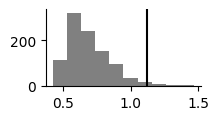

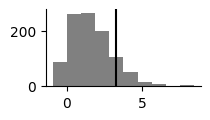

p(projection) = 0.022 p(energy) = 0.124


In [184]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000

task_embedded = hopfield_embeddings_all[noise].embedding_model.transform(np.mean(task, axis=0).reshape(1,-1))
rest_embedded = hopfield_embeddings_all[noise].embedding_model.transform(np.mean(rest, axis=0).reshape(1,-1))
true_diff = norm(task_embedded - rest_embedded)

energy_rest = hopfield_embeddings_all[noise].hopnet.energy(np.mean(rest, axis=0))
energy_task = hopfield_embeddings_all[noise].hopnet.energy(np.mean(task, axis=0))
true_energy_diff = energy_task - energy_rest

rest_n = rest.shape[0]
task_n = task.shape[0]

all_data = np.vstack((rest, task))

diffs = []
energy_diffs = []

for p in range(num_perm):
    perm_i = random.permutation(np.arange(all_data.shape[0]))
    task_perm = all_data[perm_i, :][:task_n, :]
    rest_perm = all_data[perm_i, :][task_n:(task_n+rest_n), :]
    
    task_perm_embedded = hopfield_embeddings_all[noise].embedding_model.transform(np.mean(task_perm, axis=0).reshape(1,-1))
    rest_perm_embedded = hopfield_embeddings_all[noise].embedding_model.transform(np.mean(rest_perm, axis=0).reshape(1,-1))
    diffs.append(norm(task_perm_embedded - rest_perm_embedded))
    
    energy_rest = hopfield_embeddings_all[noise].hopnet.energy(np.mean(rest_perm, axis=0))
    energy_task = hopfield_embeddings_all[noise].hopnet.energy(np.mean(task_perm, axis=0))
                                                               
    energy_diffs.append(energy_task - energy_rest)                                                        

plt.figure(figsize=(2,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_task_vs_rest.pdf')
plt.show()

plt.figure(figsize=(2,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig('../data_out/fig/permtest_task_vs_rest_energy.pdf')
plt.show()


print('p(projection) =', (diffs>true_diff).sum()/num_perm,
      'p(energy) =', (energy_diffs>true_energy_diff).sum()/num_perm)
    

p = 0.001998001998001998


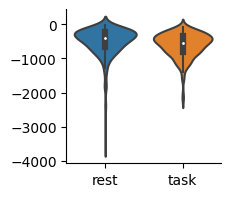

In [181]:
# framewise energy

energy_rest = [hopfield_embeddings_all[noise].hopnet.energy(rest[i, :]) for i in range(rest.shape[0])]
energy_task = [hopfield_embeddings_all[noise].hopnet.energy(task[i, :]) for i in range(rest.shape[0])]

df = pd.DataFrame({
    'rest': energy_rest,
    'task': energy_task
})

plt.figure(figsize=(2,2))
sns.violinplot(data=df)
sns.despine()


from mlxtend.evaluate import permutation_test
print( "p =", permutation_test(energy_task, energy_rest,
                           method='approximate',
                           num_rounds=1000,
                           seed=42))

## Hopfield embeddings vs. various activation maps

../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz
../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz
../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz
../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/language_association-test_z_FDR_0.01.nii.gz
../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz
../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz
../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz
../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz
../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz
../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz
../data_in/maps/decision_association-test_z_FDR_0.01.nii.gz
../data_in/maps/working memory_association-test_z_FDR_0.01.nii.gz
../data_in/maps/face_association-test_z_FDR_0.01.nii.gz


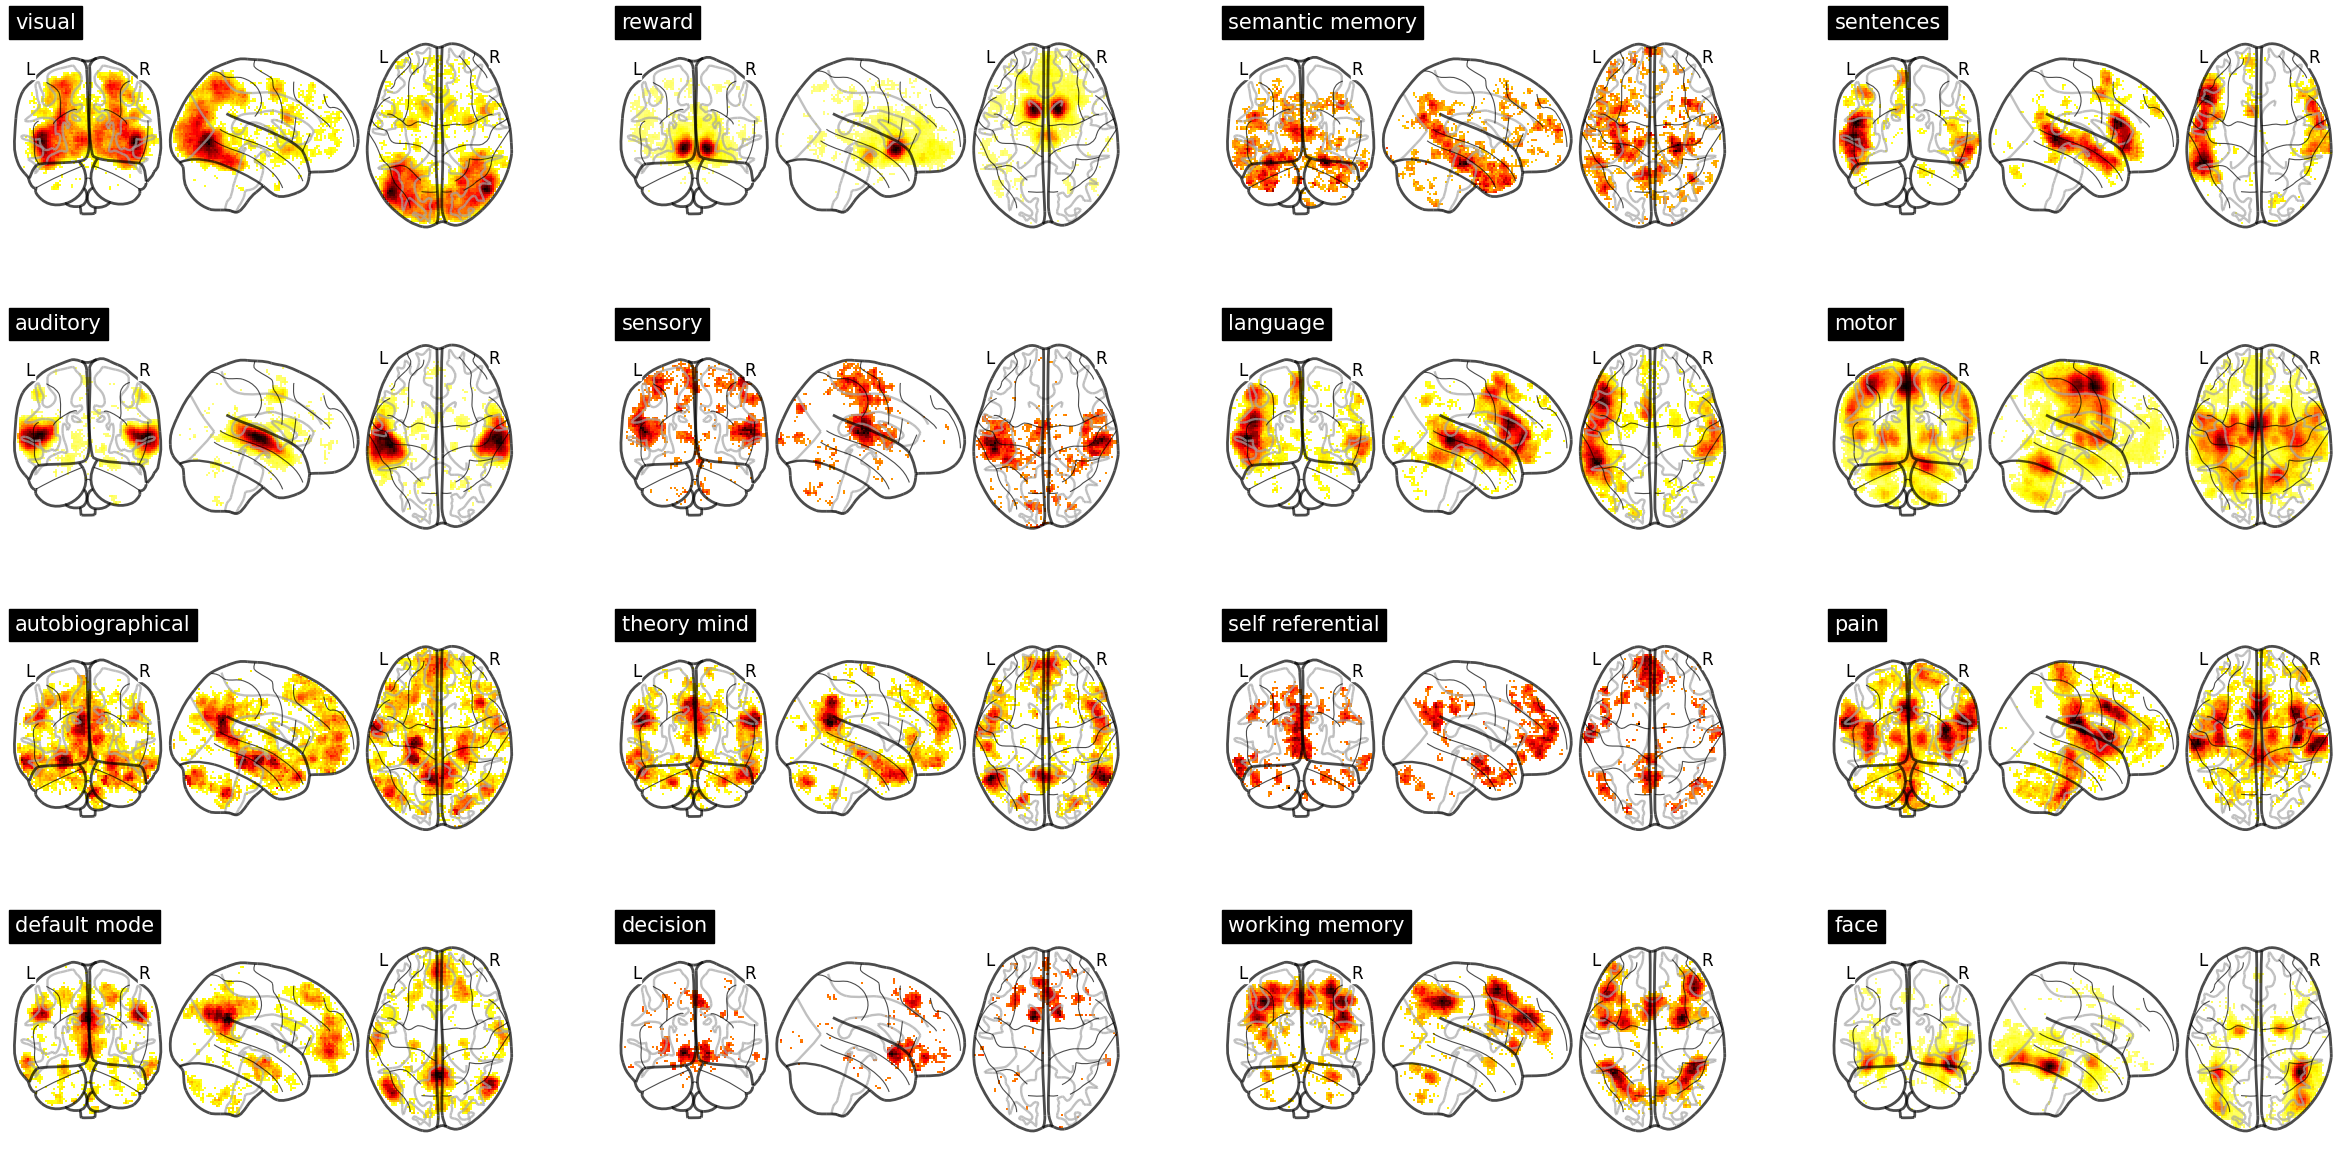

In [186]:
# load in Neurosynth maps

fig, axes = plt.subplots(4, 4, figsize=(30, 15))

maps = []
for i, f in enumerate(glob('../data_in/maps/*association-test*')):
    print(f)
    maps.append(network.State(f))
    plotting.plot_glass_brain(f, figure = fig, axes = axes.flat[i], title = f.split('/')[-1].split('_association-test')[0])
plt.show()

In [191]:
# load some resting state data
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob('bochum-???.tsv', root_dir=root_dir):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(root_dir + f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(root_dir + 'FD_' + filename + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


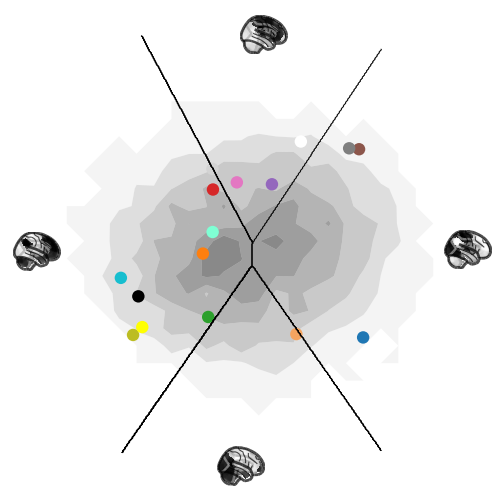

In [200]:
import matplotlib.colors as mcolors
npoise= 0.37

ax = hopfield_embeddings_all[noise].plot(np.array(all_ts), plot_type='contourf',
                             density_bins=30, density_sigma=0, levels=6, alpha=0.5, cmap='gray_r',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

colseries = list(mcolors.TABLEAU_COLORS.values()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
colors = np.array(colseries[:len(maps)])

ax = hopfield_embeddings_all[noise].plot(np.tanh(np.array(maps)), alpha=1, s=80, c=colors, plot_type='scatter',
                        ax=ax.figure.add_axes(ax.get_position(), polar=True, frameon=False),
                        attractor_plot_type='glassbrain',
                        attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
#ax.set_axisbelow(True)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/neurosynth.pdf')

In [194]:
tmp = list(mcolors.TABLEAU_COLORS.keys()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
{f : tmp[i] for i, f in enumerate(glob('../data_in/maps/*association-test*'))}

{'../data_in/maps/visual_association-test_z_FDR_0.01.nii.gz': 'tab:blue',
 '../data_in/maps/reward_association-test_z_FDR_0.01.nii.gz': 'tab:orange',
 '../data_in/maps/semantic memory_association-test_z_FDR_0.01.nii.gz': 'tab:green',
 '../data_in/maps/sentences_association-test_z_FDR_0.01.nii.gz': 'tab:red',
 '../data_in/maps/auditory_association-test_z_FDR_0.01.nii.gz': 'tab:purple',
 '../data_in/maps/sensory_association-test_z_FDR_0.01.nii.gz': 'tab:brown',
 '../data_in/maps/language_association-test_z_FDR_0.01.nii.gz': 'tab:pink',
 '../data_in/maps/motor_association-test_z_FDR_0.01.nii.gz': 'tab:gray',
 '../data_in/maps/autobiographical_association-test_z_FDR_0.01.nii.gz': 'tab:olive',
 '../data_in/maps/theory mind_association-test_z_FDR_0.01.nii.gz': 'tab:cyan',
 '../data_in/maps/self referential_association-test_z_FDR_0.01.nii.gz': 'black',
 '../data_in/maps/pain_association-test_z_FDR_0.01.nii.gz': 'white',
 '../data_in/maps/default mode_association-test_z_FDR_0.01.nii.gz': 'yell